In [1]:
%matplotlib inline  

import os
import re
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json
from result_parser import get_exp_result
from utils.distribution import distr_profile


#fig_width = 10
#plt.rcParams["figure.figsize"] = (fig_width, 6)
#plt.rcParams['font.size'] = 22



Bad key text.latex.preview in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba


=== cifar10 - cossim_gbalan_vi3_r0 - shard10 - select100*0.1 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [63.72, 64.58, 64.46] -> max: 64.46
target_acc: 61.23700, 95% of bacc 

required epoch
[396, 299, 304]
['1.00x', '1.32x', '1.30x']
required time_simu
[2742.0, 1857.0, 1882.0]
['1.00x', '1.48x', '1.46x']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



=== cifar10 - cossim_gbalan_vi3_r1 - shard10 - select100*0.1 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [64.28, 64.77, 64.81] -> max: 64.77
target_acc: 61.53150, 95% of bacc 

required epoch
[360, 296, 320]
['1.00x', '1.22x', '1.12x']
required time_simu
[2483.0, 1917.0, 2079.0]
['1.00x', '1.30x', '1.19x']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



=== cifar10 - cossim_gbalan_vi3_r2 - shard10 - select100*0.1 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [64.29, 64.77, 65.18] -> max: 64.77
target_acc: 61.53150, 95% of bacc 

required epoch
[308, 273, 257]
['1.00x', '1.13x', '1.20x']
required time_simu
[2131.0, 1874.0, 1736.0]
['1.00x', '1.14x', '1.23x']

=== cifar10 - cossim_gbalan_vi3_r0 - shard10 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [60.25, 63.39, 63.2] -> max: 63.2
target_acc: 60.04000, 95% of bacc 

required epoch
[470, 331, 298]
['1.00x', '1.42x', '1.58x']
required time_simu
[2823.0, 1713.0, 1523.0]
['1.00x', '1.65x', '1.85x']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



=== cifar10 - cossim_gbalan_vi3_r1 - shard10 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [59.65, 61.58, 62.57] -> max: 61.58
target_acc: 58.50100, 95% of bacc 

required epoch
[386, 312, 281]
['1.00x', '1.24x', '1.37x']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


required time_simu
[2307.0, 1655.0, 1435.0]
['1.00x', '1.39x', '1.61x']

=== cifar10 - cossim_gbalan_vi3_r2 - shard10 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [62.07, 61.09, 61.52] -> max: 61.09
target_acc: 58.03550, 95% of bacc 

required epoch
[286, 256, 244]
['1.00x', '1.12x', '1.17x']
required time_simu
[1691.0, 1428.0, 1358.0]
['1.00x', '1.18x', '1.25x']

=== cifar10 - cossim_gbalan_vi3_r0 - shard2 - select100*0.1 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [50.38, 55.6, 56.52] -> max: 55.6
target_acc: 52.82000, 95% of bacc 

required epoch
[-1, 239, 217]
['-239.00x', '1.00x', '1.10x']
required time_simu
[-1, 1648.0, 1487.0]
['-1648.00x', '1.00x', '1.11x']

=== cifar10 - cossim_gbalan_vi3_r1 - shard2 - select100*0.1 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [53.57, 58.57, 58.66] -> max: 58.57
target_acc: 55.64150, 95% of bacc 

required epoch
[-1, 339, 324]
['-339.00x', '1.00x', '1.05x']
required time_simu
[-1, 2166.0, 2057.0]
['-2166.00x', '1.00x', '1.05x']

=== cifar10 - cossim_gbalan_vi3_r2 - shard2 - select100*0.1 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [52.5, 56.6, 57.17] -> max: 56.6
target_acc: 53.77000, 95% of bacc 

required epoch
[-1, 312, 258]
['-312.00x', '1.00x', '1.21x']
required time_simu
[-1, 2192.0, 1818.0]
['-2192.00x', '1.00x', '1.21x']

=== cifar10 - cossim_gbalan_vi3_r0 - shard2 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [44.09, 47.85, 48.56] -> max: 47.85
target_acc: 45.45750, 95% of bacc 

required epoch
[-1, 332, 263]
['-332.00x', '1.00x', '1.26x']
required time_simu
[-1, 1988.0, 1547.0]
['-1988.00x', '1.00x', '1.29x']

=== cifar10 - cossim_gbalan_vi3_r1 - shard2 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



bacc summary: [46.3, 55.36, 55.42] -> max: 55.36
target_acc: 52.59200, 95% of bacc 

required epoch
[-1, 358, 299]
['-358.00x', '1.00x', '1.20x']
required time_simu
[-1, 1866.0, 1583.0]
['-1866.00x', '1.00x', '1.18x']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



=== cifar10 - cossim_gbalan_vi3_r2 - shard2 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']

bacc summary: [41.69, 50.61, 53.22] -> max: 50.61
target_acc: 48.07950, 95% of bacc 

required epoch
[-1, 329, 295]
['-329.00x', '1.00x', '1.12x']
required time_simu
[-1, 1978.0, 1762.0]
['-1978.00x', '1.00x', '1.12x']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


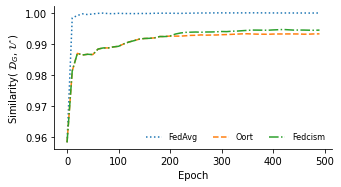

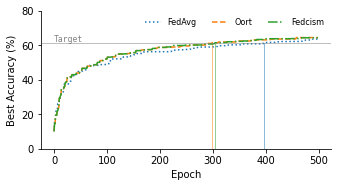

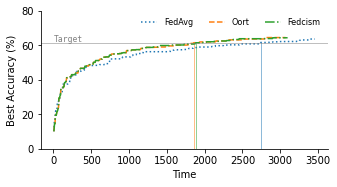

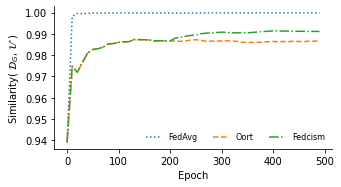

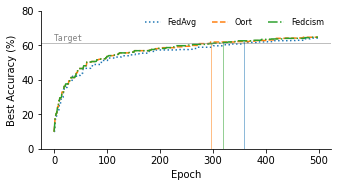

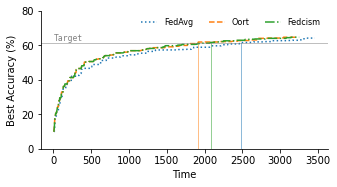

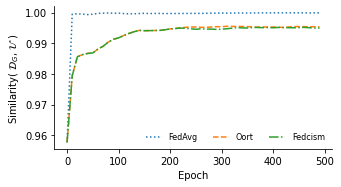

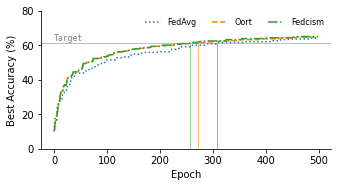

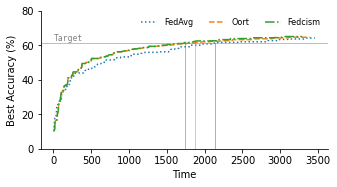

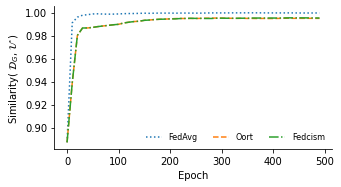

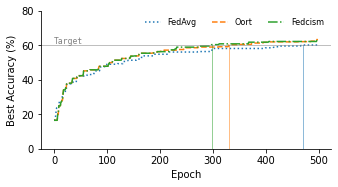

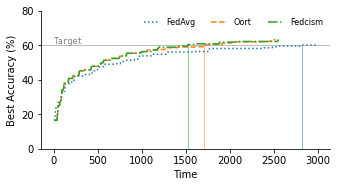

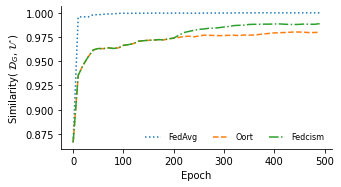

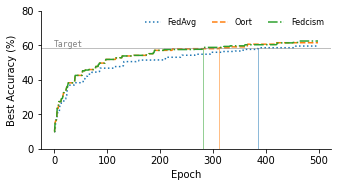

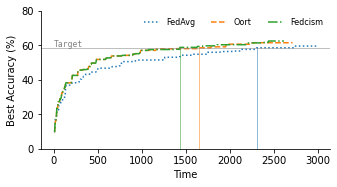

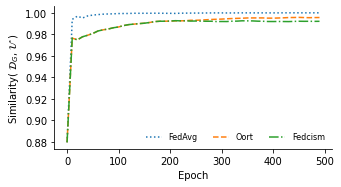

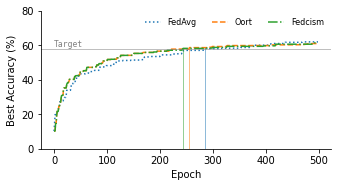

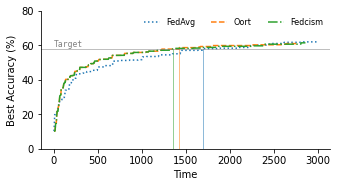

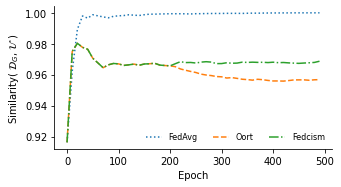

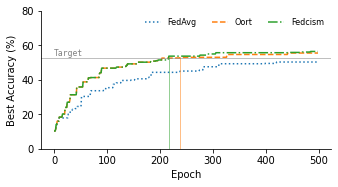

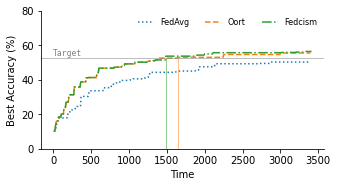

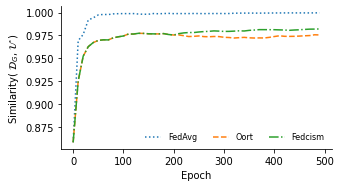

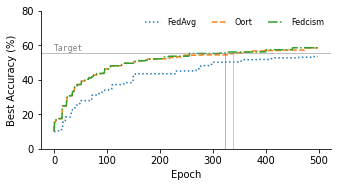

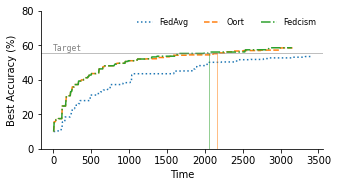

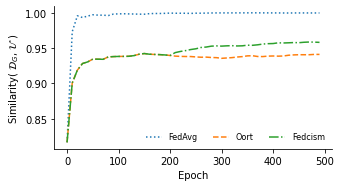

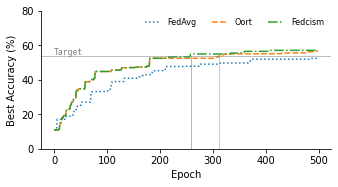

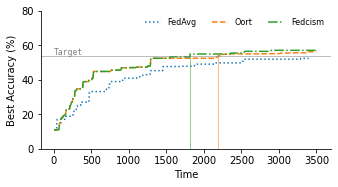

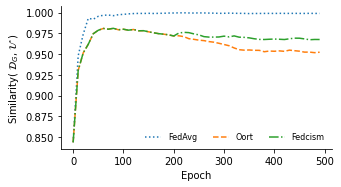

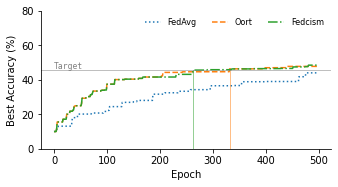

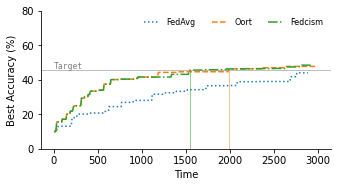

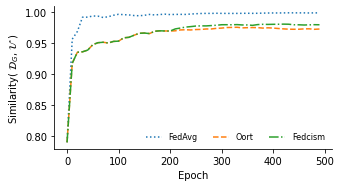

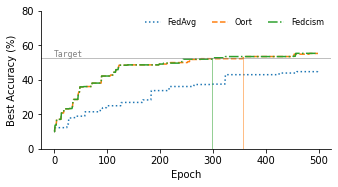

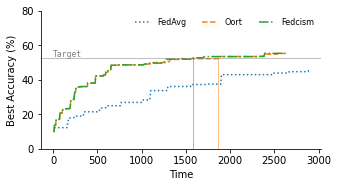

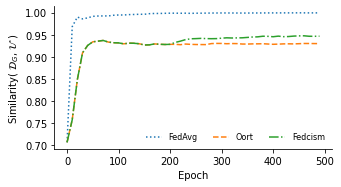

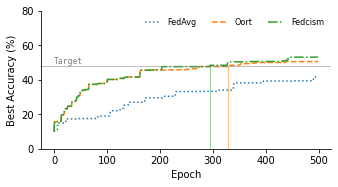

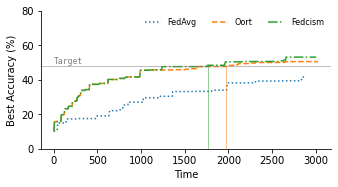

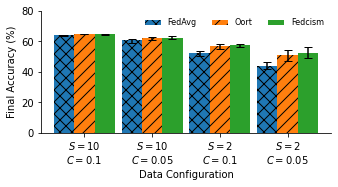

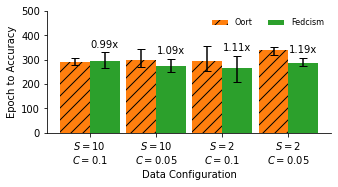

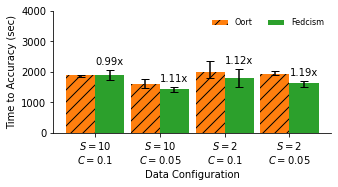

In [8]:
data_distr = 'gbalan' # htail, cus
VI = 3
epoch = 500
fig_zoom = 0.3

# compare over datasets
acc_threshold = 95
metrics = {'ACC':[], 'ETA':[], 'TTA':[]}
x_labels = []
y_labels = ['Final Accuracy (%)',
            'Epoch to Accuracy',
            'Time to Accuracy (sec)']
y_lim = [80, epoch, 4000]
'''
y_labels = ['Final Accuracy(%)',
            'Epoch to Reach {}% Best Acc'.format(acc_threshold),
            'Time to Reach {}% Best Acc'.format(acc_threshold)]
'''
legends = {'fedavg':'FedAvg', 'oort_e0.8':'Oort', 'algo3_deg1_e0.8_wof100':'Fedcism'}
textures = ['xx', '//', None]

for dataset in ['cifar10']:
    for shard_per_user in [10, 2]:
        for frac in [0.1, 0.05]:
            x_labels.append('$S={}$\n$C={}$'.format(shard_per_user, frac))
            bacc_stack = []
            TTAe_stack = []
            TTAt_stack = []
            
            for RUN in range(3):
        
                data_distr_file = '{}_dict_users_vi{}_r{}.pkl'.format(data_distr, VI, RUN)
                result_folder = 'cossim_{}_vi{}_r{}'.format(data_distr, VI, RUN)
                '''if frac == 0.1:
                    dpath = 'save/{}/data_distr/num100/shard{}/{}'.format(dataset, shard_per_user, data_distr_file)
                    profile = distr_profile(dpath)
                    _ =profile.plot_local_distr(shard_per_user)
    '''
                algos, color_algos, bacc_algos, required_time = get_exp_result(
                    dataset, data_distr, VI, RUN, data_distr_file, result_folder, legends,
                    shard_per_user, frac, acc_threshold, show_fig=True, save=True)

                bacc_stack.append(bacc_algos)
                TTAe_stack.append(required_time['epoch'])
                TTAt_stack.append(required_time['time_simu'])
            
            metrics['ACC'].append(bacc_stack)
            metrics['ETA'].append(TTAe_stack)
            metrics['TTA'].append(TTAt_stack)
    
    # summary 
    x = np.arange(len(x_labels))
    for i, (k, v) in enumerate(metrics.items()):
        fig, ax = plt.subplots(figsize=(16*fig_zoom, 9*fig_zoom))
        #plt.title('{} - {} - vi{}'.format(dataset, data_distr, VI), y=1.1)
        if data_distr == 'cus': # alias
            fig_name = '{}_{}_vi{}'.format(k, 'sparsez', VI)
        else:            
            fig_name = '{}_{}_vi{}'.format(k, data_distr, VI)
        fig_path = os.path.join('save', dataset, 'fig', fig_name)
        
        cur_algos = algos
        cur_v_T = v_T = np.array(v).T
        if 'TA' in k:
            cur_algos = algos[1:]
            cur_v_T = v_T[1:] # [algo][run][data_config]
        for aidx, algo in enumerate(cur_algos):
            w = 0.9/len(cur_algos)
            y_avg = cur_v_T[aidx].mean(axis=0)
            y_max = cur_v_T[aidx].max(axis=0)
            y_min = cur_v_T[aidx].min(axis=0)
            y_err = np.vstack((y_max-y_avg, y_avg-y_min))
            
            if k == 'ACC':
                p = ax.bar(x+aidx*w-0.45+w/2, y_avg, yerr=y_err, 
                            label=legends[algo], width=w,
                            capsize=4, hatch=textures[aidx])
            else:
                p = ax.bar(x+aidx*w-0.45+w/2, y_avg, yerr=y_err, 
                            label=legends[algo], width=w, color=color_algos[aidx+1],
                            capsize=4, hatch=textures[aidx+1])
                
                if aidx == 0:
                    base_yavg = y_avg
                elif aidx == 1:
                    txt = ['{:.2f}x'.format(x) for x in base_yavg/y_avg]
                    ax.bar_label(p, labels=txt, padding=3)

        ax.set_ylabel(y_labels[i])
        ax.set_xlabel('Data Configuration')
        ax.set_ylim(top=y_lim[i])
        ax.set_xticks(x, labels=x_labels)#, rotation='vertical')
        #fig.legend(fancybox=True, shadow=True, fontsize=16,
        #                      loc='lower left', bbox_to_anchor=(1, 0))
        ax.legend(fontsize=8, ncol=len(cur_algos), frameon=False)

        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
        fig.tight_layout()
        fig.savefig('{}.{}'.format(fig_path, 'png'), format='png', transparent=True)
        fig.savefig('{}.{}'.format(fig_path, 'eps'), format='eps', transparent=True)